# Advent of Code 2016

## Day 22: Grid Computing

### Part One

You gain access to a massive storage cluster arranged in a grid; each storage node is only connected to the four nodes directly adjacent to it (three if the node is on an edge, two if it's in a corner).

You can directly access data only on node `/dev/grid/node-x0-y0`, but you can perform some limited actions on the other nodes:

- You can get the disk usage of all nodes (via `df`). The result of doing this is in your puzzle input.
- You can instruct a node to move (not copy) all of its data to an adjacent node (if the destination node has enough space to receive the data). The sending node is left empty after this operation.

Nodes are named by their position: the node named `node-x10-y10` is adjacent to nodes `node-x9-y10`, `node-x11-y10`, `node-x10-y9`, and `node-x10-y11`.

Before you begin, you need to understand the arrangement of data on these nodes. Even though you can only move data between directly connected nodes, you're going to need to rearrange a lot of the data to get access to the data you need. Therefore, you need to work out how you might be able to shift data around.

To do this, you'd like to count the number of viable pairs of nodes. A viable pair is any two nodes (A,B), regardless of whether they are directly connected, such that:

- Node A is not empty (its `Used` is not zero).
- Nodes A and B are not the same node.
- The data on node A (its `Used`) would fit on node B (its `Avail`).

How many viable pairs of nodes are there?

In [1]:
from collections import namedtuple
import re

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Solution Part One

I start with defining a custom datatype for my nodes, just for convenience and to keep my sanity while coding. If you don't want any methods or state changes, `namedtuple` is great. They sort and hash just like regular tuples, but the fields have names.

In [2]:
Node = namedtuple('Node', ('x', 'y', 'size', 'used', 'avail'))

Mandatory horrific regex to parse the input.

In [3]:
r = re.compile(r'[/a-z\-]+(\d+)-y(\d+)\s+(\d+)T\s+(\d+)T\s+(\d+)T')

Just put all the inputs into a single list.

In [4]:
nodes = []
with open('input.txt') as f:
    for line in f:
        m = r.match(line)
        if m:
            node = Node(*map(int, m.groups()))
            nodes.append(node)

Find the **viable pairs**.

In [5]:
nodes_by_used = sorted(nodes, key=lambda n: n.used)
nodes_by_avail = sorted(nodes, key=lambda n: n.avail)

n_pairs = 0
for a in nodes_by_used:
    if a.used == 0:
        continue
    for b in reversed(nodes_by_avail):
        if a is b:
            continue
        if a.used > b.avail:
            break
        n_pairs += 1

print('Answer Part One:', n_pairs)

Answer Part One: 860


### Part Two

Now that you have a better understanding of the grid, it's time to get to work.

Your goal is to gain access to the data which begins in the node with `y=0` and the highest `x` (that is, the node in the top-right corner).

For example, suppose you have the following grid:

```
Filesystem            Size  Used  Avail  Use%
/dev/grid/node-x0-y0   10T    8T     2T   80%
/dev/grid/node-x0-y1   11T    6T     5T   54%
/dev/grid/node-x0-y2   32T   28T     4T   87%
/dev/grid/node-x1-y0    9T    7T     2T   77%
/dev/grid/node-x1-y1    8T    0T     8T    0%
/dev/grid/node-x1-y2   11T    7T     4T   63%
/dev/grid/node-x2-y0   10T    6T     4T   60%
/dev/grid/node-x2-y1    9T    8T     1T   88%
/dev/grid/node-x2-y2    9T    6T     3T   66%
```

In this example, you have a storage grid 3 nodes wide and 3 nodes tall. The node you can access directly, `node-x0-y0`, is almost full. The node containing the data you want to access, `node-x2-y0` (because it has `y=0` and the highest `x` value), contains 6 terabytes of data - enough to fit on your node, if only you could make enough space to move it there.

Fortunately, `node-x1-y1` looks like it has enough free space to enable you to move some of this data around. In fact, it seems like all of the nodes have enough space to hold any node's data (except `node-x0-y2`, which is much larger, very full, and not moving any time soon). So, initially, the grid's capacities and connections look like this:

```
( 8T/10T) --  7T/ 9T -- [ 6T/10T]
    |           |           |
  6T/11T  --  0T/ 8T --   8T/ 9T
    |           |           |
 28T/32T  --  7T/11T --   6T/ 9T
```

The node you can access directly is in parentheses; the data you want starts in the node marked by square brackets.

In this example, most of the nodes are interchangable: they're full enough that no other node's data would fit, but small enough that their data could be moved around. Let's draw these nodes as `.`. The exceptions are the empty node, which we'll draw as `_`, and the very large, very full node, which we'll draw as `#`. Let's also draw the goal data as `G`. Then, it looks like this:

```
(.) .  G
 .  _  .
 #  .  .
```

The goal is to move the data in the top right, `G`, to the node in parentheses. To do this, we can issue some commands to the grid and rearrange the data:

- Move data from `node-y0-x1` to `node-y1-x1`, leaving `node-y0-x1` empty:
```
(.) _  G
 .  .  .
 #  .  .
```
- Move the goal data from `node-y0-x2` to `node-y0-x1`:
```
(.) G  _
 .  .  .
 #  .  .
```
- At this point, we're quite close. However, we have no deletion command, so we have to move some more data around. So, next, we move the data from `node-y1-x2` to `node-y0-x2`:
```
(.) G  .
 .  .  _
 #  .  .
```
- Move the data from `node-y1-x1` to `node-y1-x2`:
```
(.) G  .
 .  _  .
 #  .  .
```
- Move the data from `node-y1-x0` to `node-y1-x1`:
```
(.) G  .
 _  .  .
 #  .  .
```
- Next, we can free up space on our node by moving the data from `node-y0-x0` to `node-y1-x0`:
```
(_) G  .
 .  .  .
 #  .  .
```
- Finally, we can access the goal data by moving the it from `node-y0-x1` to `node-y0-x0`:
```
(G) _  .
 .  .  .
 #  .  .
```

So, after 7 steps, we've accessed the data we want. Unfortunately, each of these moves takes time, and we need to be efficient:

What is the fewest number of steps required to move your goal data to `node-x0-y0`?


### Solution Part Two

First, let's see what we've got. Let's plot the `Size` and `Used` for the nodes.

In [6]:
used = []
size = []

for node in sorted(nodes, key=lambda n: (n.y, n.x)):
    if node.x == 0:
        used.append([])
        size.append([])
    used[-1].append(node.used)
    size[-1].append(node.size)

used = np.array(used)
size = np.array(size)

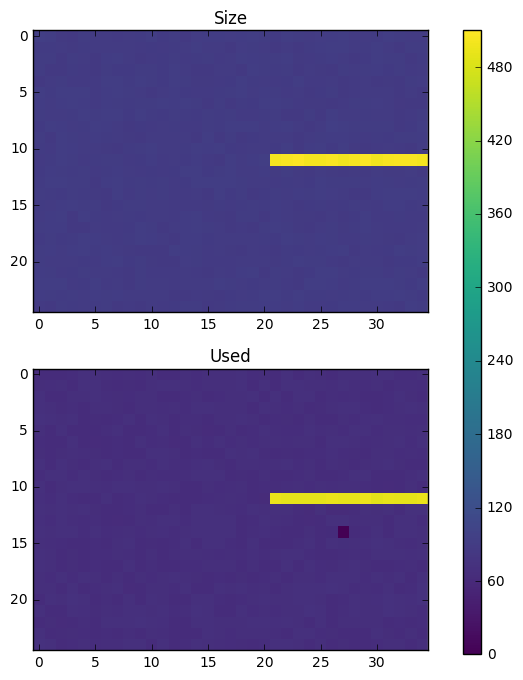

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
axes[0].imshow(size, interpolation='none', vmin=0, vmax=np.max(size), cmap='viridis')
axes[0].set_title('Size')
im = axes[1].imshow(used, interpolation='none', vmin=0, vmax=np.max(size), cmap='viridis')
axes[1].set_title('Used')

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.9, 0.12, 0.03, 0.78])
fig.colorbar(im, cax=cax)

Interesting, there seems to be a row of huge, essentially immobile, nodes and only one empty node. Let's change the colormap to be even more clear.

In [8]:
# There must be a better way!
from matplotlib.colors import LinearSegmentedColormap

c_dict = {
    'red':   [(0.00, 0.99, 0.99),
              (0.02, 0.99, 0.24),
              (0.16, 0.24, 0.17),
              (0.20, 0.17, 0.28),
              (1.00, 0.28, 0.28)],
    
    'green': [(0.00, 0.90, 0.90),
              (0.02, 0.90, 0.74),
              (0.16, 0.74, 0.45),
              (0.20, 0.45, 0.09),
              (1.00, 0.09, 0.09)],
    
    'blue':  [(0.00, 0.14, 0.14),
              (0.02, 0.14, 0.46),
              (0.16, 0.46, 0.56),
              (0.20, 0.56, 0.41),
              (1.00, 0.41, 0.41)],
}

custom_cmap = LinearSegmentedColormap('Custom', c_dict)

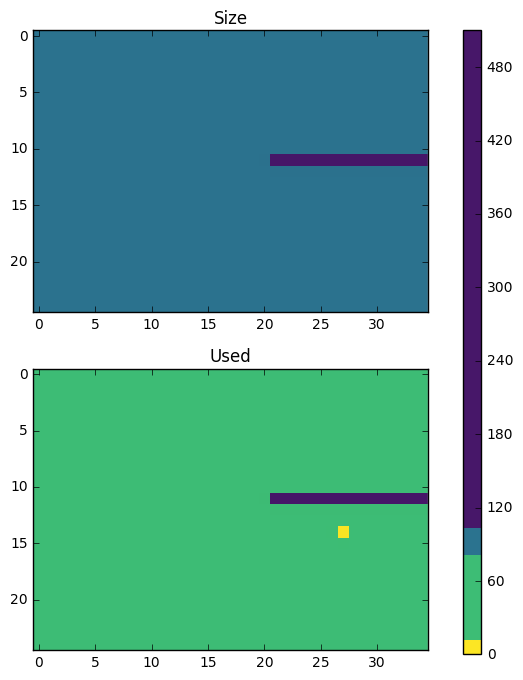

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
axes[0].imshow(size, interpolation='none', vmin=0, vmax=np.max(size), cmap=custom_cmap)
axes[0].set_title('Size')
im = axes[1].imshow(used, interpolation='none', vmin=0, vmax=np.max(size), cmap=custom_cmap)
axes[1].set_title('Used')

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.9, 0.12, 0.03, 0.78])
fig.colorbar(im, cax=cax)

By now it is clear that apart from the immobile row, any data fits anywhere. So, first we need to move the hole to `node-x27-y14` to `node-x33-y0`. To do this, we need to move the hole to `node-x20-y11` in order to avoid the immobile row. This takes 7 + 3 = 10 steps. Then the path is clear and we get to `node-x33-y0` after another 13 + 11 = 24 steps. Then move the Goal data to `node-x33-y0`.

From this point, we follow the scheme described in the example. To move the Goal data from `node-x(n)-y0` to `node-x(n-1)-y0`, first move the hole to `node-x(n-1)-y0`, avoiding the goal data and then move the goal data. Each iteration takes 5 steps. All in all 33x5.

Thus, the number of steps needed is 10 + 24 + 1 + 33 x 5 = 200.

In [10]:
10 + 24 + 1 + 33*5

200